# Springboard Take Home Challenge -1

In [260]:
##Import libraries
import json
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression


sns.set(style = 'whitegrid')
sns.set_palette('bright')
%matplotlib inline

#  Q1: Exploratory Data Analysis

In [135]:
#Read the json login file using pandas
df = pd.read_json('logins.json')
#Print the data
df.head(5)

login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21

In [136]:
### Explore the type of data stored in the json file
df['login_time'].describe()

count                   93142
unique                  92265
top       1970-02-12 11:16:53
freq                        3
first     1970-01-01 20:12:16
last      1970-04-13 18:57:38
Name: login_time, dtype: object

Based on the above output, the login counts are taken between January to April 1970 at various times of the day, so we can explore the following questions: 

    1. Create a timeseries plot of the logins to understand the trend?
    
    2. How does the login count vary by time of the day i.e. by 15 minute interval?
    
    3. How does the login count vary by day of week? 
    
    4. How does the login count vary by month of the year? Is there a pattern?
    

##  Aggregate  login   counts   based   on   15 minute   time   intervals

In [137]:
#Resample the dataframe by 15 minutes and store the counts in a new dataframe
df_log_time = df.resample("15min", on = 'login_time').count()
df_log_time.rename(columns = {'login_time':'count'}, inplace=True)
df_log_time.reset_index(inplace=True)
df_log_time.head()

login_time  count
0 1970-01-01 20:00:00      2
1 1970-01-01 20:15:00      6
2 1970-01-01 20:30:00      9
3 1970-01-01 20:45:00      7
4 1970-01-01 21:00:00      1

In [81]:
## Split the dataframe into date,time, day using Pandas datetime and save as df_log_time
df_log_time['date'] = pd.to_datetime(df_log_time['login_time']).dt.date
df_log_time['time']= pd.to_datetime(df_log_time['login_time']).dt.time
df_log_time['day'] = df_log_time['login_time'].dt.day_name()
df_log_time['month'] = df_log_time['login_time'].dt.month_name()

df_log_time.describe()

count
count  9788.000000
mean      9.515938
std       8.328818
min       0.000000
25%       3.000000
50%       7.000000
75%      13.000000
max      73.000000

In [82]:
df_log_time.tail()

login_time  count        date      time     day  month
9783 1970-04-13 17:45:00      5  1970-04-13  17:45:00  Monday  April
9784 1970-04-13 18:00:00      5  1970-04-13  18:00:00  Monday  April
9785 1970-04-13 18:15:00      2  1970-04-13  18:15:00  Monday  April
9786 1970-04-13 18:30:00      7  1970-04-13  18:30:00  Monday  April
9787 1970-04-13 18:45:00      6  1970-04-13  18:45:00  Monday  April

In [83]:
### Check for data quality issues, such as negative values or nan in count

#Nans
print("There are {} NaNs in count.".format(sum(df_log_time['count'].isna())))
print("There are {} NaNs in login time.".format(sum(df_log_time['login_time'].isna())))

#Login time
print("Are there any negative values in count?: {}".format(any(df_log_time['count']<0)))


There are 0 NaNs in count.
There are 0 NaNs in login time.
Are there any negative values in count?: False


Based on the above exploration, there doesn't seem to be any data quality issues yet, but we may find something as we progress through the analysis. 

## Analyze and visualize trends in the resulting time series of login counts

### Create a timeseries plot of all the logins for each month

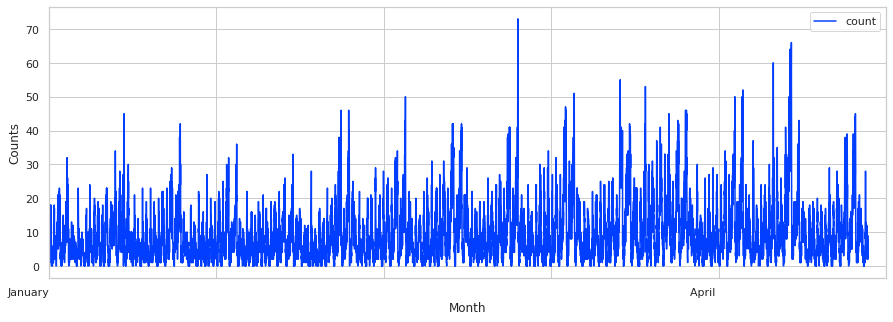

In [116]:
###  Create a timeseries plot of the aggregated login counts by month
fig, ax = plt.subplots(figsize = (15,5))
df_log_time.plot(y = 'count',kind='line', ax = ax, x = 'month')
locs, labels=plt.xticks()
x_ticks = []
new_xticks=['January', ' ', ' ',' ', 'April ', ' ']
plt.xticks(locs,new_xticks,horizontalalignment='right')
plt.xlabel('Month')
plt.ylabel('Counts')
plt.show()

The above plot shows a time-series plot of all the login times over a 4 month period. There seems to be a sinusoidal pattern with the login counts increasing slowly.

### Create a plot of the average number of logins by time of the day

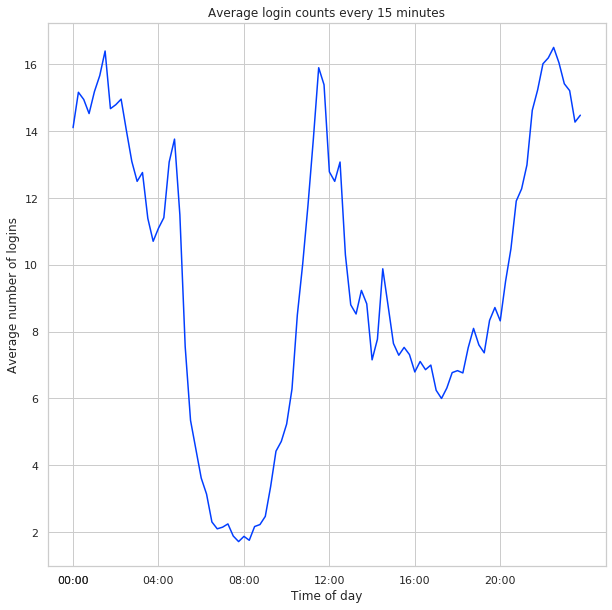

In [118]:
df_avg_time_logins = df_log_time.groupby('time').mean()
df_avg_time_logins.reset_index(inplace=True)

#Create plot
fig, ax = plt.subplots(figsize = (10,10))
ax = sns.lineplot(x = 'time', y = 'count', data = df_avg_time_logins)
plt.xticks(['00:00:00', '04:00:00', '08:00:00', '12:00:00', '16:00:00', '20:00:00', '00:00:00'])
ax.set(title = 'Average login counts every 15 minutes')
plt.xlabel('Time of day')
plt.ylabel('Average number of logins')
plt.show()


The above plot shows the average login counts every 15 minutes. The plot shows that the average number of logins were least between 6 AM to 8 AM and it peaked early in the morning around 2 AM, in the middle of the day around noon, and late in the evening after 9 PM. 


### Create a plot of the total and average number of logins by day of the week

In [119]:
df_avg_day_logins = pd.DataFrame()

### Total logins by day of week
df_avg_day_logins['total'] = df_log_time.groupby('day').sum()['count']


### Average login by day of week
df_avg_day_logins['average'] = df_log_time.groupby('day').mean()['count']

##Reset index and print
df_avg_day_logins.reset_index(inplace=True)
df_avg_day_logins.head(7)

day  total    average
0     Friday  15208  10.561111
1     Monday   8823   6.213380
2   Saturday  19377  13.456250
3     Sunday  18167  12.615972
4   Thursday  11960   8.794118
5    Tuesday   9268   6.895833
6  Wednesday  10339   7.692708

In [120]:
## Re-order by day of week
df_avg_day_logins['day'] = pd.Categorical(df_avg_day_logins['day'], categories=
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
    ordered=True)

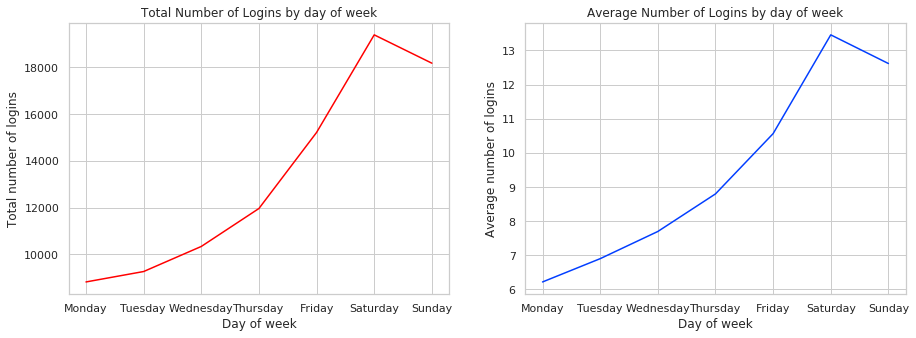

In [121]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
ax1 = sns.lineplot(x = 'day', y = 'total', data = df_avg_day_logins, ax = ax1, color = 'red')
ax2 = sns.lineplot(x = 'day', y = 'average', data = df_avg_day_logins, ax = ax2)
ax1.set(title = 'Total Number of Logins by day of week')
ax2.set(title = 'Average Number of Logins by day of week')
ax1.set_xlabel('Day of week')
ax2.set_xlabel('Day of week')
ax1.set_ylabel('Total number of logins')
ax2.set_ylabel('Average number of logins')
plt.show()

The above plots show that the average and total logins were lowest on Monday and Tuesday but it progressively increases throughout the week and peaks on Saturdays and then starts to lower on Sundays. 

### Create a plot of the total number of logins by month

In [123]:
df_month_logins = pd.DataFrame()

### Total logins by month
df_month_logins['total'] = df_log_time.groupby('month').sum()['count']
##Reset index and print
df_month_logins.reset_index(inplace=True)
df_month_logins.head(7)

month  total
0     April  13507
1  February  24673
2   January  21239
3     March  33723

In [124]:
## Re-order by month
df_month_logins['month'] = pd.Categorical(df_month_logins['month'], categories=
    ['January','February','March','April'],
    ordered=True)

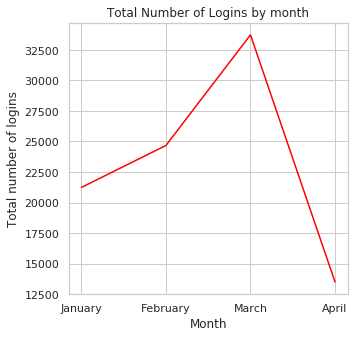

In [125]:
fig, ax1 = plt.subplots(figsize = (5,5))
ax1 = sns.lineplot(x = 'month', y = 'total', data = df_month_logins, ax = ax1, color = 'red')
ax1.set(title = 'Total Number of Logins by month')
ax1.set_xlabel('Month')
ax1.set_ylabel('Total number of logins')
plt.show()

The above plot shows that the number of logins increased from January to March but it seems like there was a sudden decline in login in April. One reason for this could be the incomplete data in April as the login counts end on April 13th. However, this trend is slightly different from what we observed in the time-series plot. To confirm this, we will resample the plot by day instead of 15 minute time intervals. 

##  Aggregate  login   counts   based   to a daily frequency

In [146]:
#Resample the dataframe by 15 minutes and store the counts in a new dataframe
df_log_daily = df.resample("1D", on = 'login_time').count()
df_log_daily.rename(columns = {'login_time':'count'}, inplace=True)
df_log_daily.head()

count
login_time       
1970-01-01    112
1970-01-02    681
1970-01-03    793
1970-01-04    788
1970-01-05    459

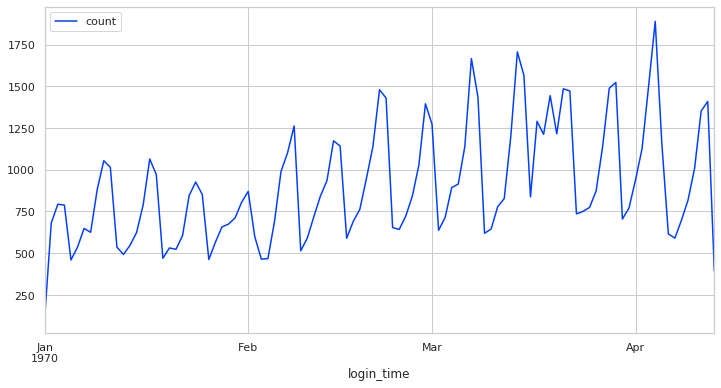

In [147]:
#Create a plot of the daily trend
df_log_daily.plot(kind='line',figsize=(12,6))

The above plot also seems to indicate that there is a general upward trend in login count by month. Next we'll  use the linearplot function to plot the average logins by day of the month. 

Text(-3.8249999999999957, 0.5, 'Counts')

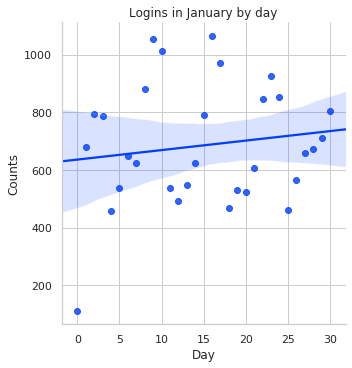

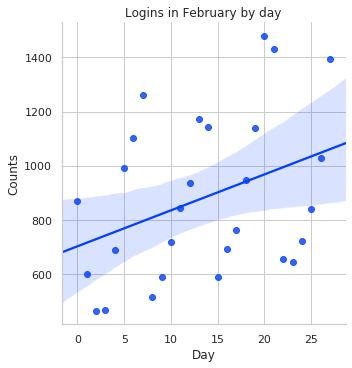

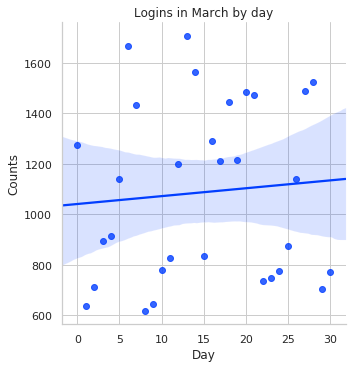

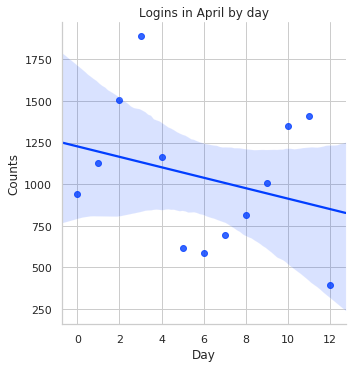

In [157]:
#plot trends by month
df_jan = df_log_daily[df_log_daily.index.month==1]
df_feb = df_log_daily[df_log_daily.index.month==2]
df_mar = df_log_daily[df_log_daily.index.month==3]
df_apr = df_log_daily[df_log_daily.index.month==4]

#Assign the xaxis for each plot
df_jan = df_jan.assign(x = range(df_jan.shape[0]))
df_feb = df_feb.assign(x = range(df_feb.shape[0]))
df_mar = df_mar.assign(x = range(df_mar.shape[0]))
df_apr = df_apr.assign(x = range(df_apr.shape[0]))

sns.lmplot(data=df_jan,x='x',y='count')
ax = plt.gca()
ax.set_title("Logins in January by day")
ax.set_xlabel('Day')
ax.set_ylabel('Counts')
sns.lmplot(data=df_feb,x='x',y='count')
ax = plt.gca()
ax.set_title("Logins in February by day")
ax.set_xlabel('Day')
ax.set_ylabel('Counts')
sns.lmplot(data=df_mar,x='x',y='count')
ax = plt.gca()
ax.set_title("Logins in March by day")
ax.set_xlabel('Day')
ax.set_ylabel('Counts')
sns.lmplot(data=df_apr,x='x',y='count')
ax = plt.gca()
ax.set_title("Logins in April by day")
ax.set_xlabel('Day')
ax.set_ylabel('Counts')

The above plots indicate that there is really no decreasing or increasing trends in login counts in January, as the number of counts are between 600 - 750. However, in February and March we see that there is an increase in the number of counts, with counts almost doubling in February, and slightly increasing in March. However, in April, there is a general decrease in trend in login count, but the number of logins in higher than January. One reason for this could be the incomplete data in April, which does not give us a clear picture of the trend in April.  

#  Q2:    Experiment and metrics design

The   neighboring   cities   of   Gotham   and   Metropolis   have   complementary   circadian   rhythms:   on 
weekdays,   Ultimate   Gotham   is   most   active   at   night,   and   Ultimate   Metropolis   is   most   active 
during   the   day.   On   weekends,   there   is   reasonable   activity   in   both   cities. 
 
However,   a   toll   bridge,   with   a   two Â­way   toll,   between   the   two   cities   causes   driver   partners   to   tend 
to   be   exclusive   to   each   city.   The   Ultimate   managers   of   city   operations   for   the   two   cities   have 
proposed   an   experiment   to   encourage   driver   partners   to   be   available   in   both   cities,   by 
reimbursing   all   toll   costs.

##  What   would   you   choose   as   the   key   measure   of   success   of   this   experiment   in  encouraging   driver   partners   to   serve   both   cities,   and   why   would   you   choose   this   metric? 

To track the effetiveness of this experiment, we would first need to understand how long each driver spends in each city. There are two ways to track this: either tracking their GPS locations in a smartphone device, or if the time of 'check in' and 'check out' at the tolls are available, we could use this to get an idea of how long each driver spends in each city by day/month. 

Based on the above plots, we noticed that the weekend activity/logins are far higher than the weekday logins, since both cities remain reasonably active on weekends. 

Thus, the  best metric to track for this experiment would be **the total time each driver spends in each city on weekends** with the goal being to ensure a driver spends equal amount of time in both cities.

## Describe   a   practical   experiment   you   would   design   to   compare   the   effectiveness   of   the  proposed   change   in   relation   to   the   key   measure   of   success.   
Please   provide   details   on:  

 a. how   you   will   implement   the   experiment 

b. what   statistical   test(s)   you   will   conduct   to   verify   the   significance   of   the 
observation 

c. how   you   would   interpret   the   results   and   provide   recommendations   to   the   city 
operations   team   along   with   any   caveats. 

a. The experiment would have to be implemented in a phased mannner. In order to avoid any bias in the data, I would propose an A/B test approach. Assuming that both cities have a fairly large number of drivers (based on the login counts in a day), I would proposed the following steps:
    
    Step 1: First, select a sample of 100 drivers.
    Step 2: Select a time period (4 weekends over a month would be a good time estimate) when you want to do a beta-testing of the experiment. Prior to that month, keep track of driver activity during weekends (over a month) before implementing the experiment and calculate the percentage of time they spend driving in each city.
    Step 3: Next notify the drivers of the experiment a day or two before the experiment starts and continue tracking their activity on weekends, after implementing the no-toll policy.
    Step 4: Next, use a Z-test for hypothesis testing, set a confidence interval (could be ~95%) and test the samples under the following hypothesis: 
    
        Ho: There is no difference in mean proportion of times spent by drivers in each city on weekends
        H1: There is a statistically significant difference in the mean proportion of times spent by drivers in each city
        

b. Here I proposed to use a Z-test to find the differences in mean because the sample size is farily large (we are choosing at least 100 drivers), despite not knowing the population variance.

c. At the end of the experiment, if the percentage of time spent by drivers in each city are somewhat similar, or if the percentage of time spent by each driver in the non-dominant city increases, then we can conclude that the toll reimbursement is effective. However, there are a few caveats to these conclusions: 

    1. It is important to implement this experiment only on normal weekends when there are no national holidays or events happening in the cities, which would add bias to the results. 
    2. Driving patterns are unpredictable and there are various other factors besides an actual ride that would cause a driver to drive from one city to another. 
    3. At the end of the experiement, both cities would have to conduct a cost-benefit analysis to esimtate the cost savings for the driver vs. the increase in revenue for each city by having drivers available in both cities. 

    
    
        
    

# Q3: Predictive   modeling 

In [180]:
## Load the json file and convert to a dataframe
file = 'ultimate_data_challenge.json'

with open(file) as f:
    data = json.loads(f.read())
    
df_ultimate = pd.DataFrame(data)

df_ultimate.head(10)


city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   
5      Winterfell                       2  2014-01-09                   3.5   
6         Astapor                       1  2014-01-24                   NaN   
7      Winterfell                       2  2014-01-28                   5.0   
8      Winterfell                       2  2014-01-21                   4.5   
9      Winterfell                       1  2014-01-03                   NaN   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   
5       1.00     2014-06-06   iPhone        0.0                 True   
6       1.00     2014-01-25  Android        0.0                False   
7       1.00     2014-01-29   iPhone        0.0                False   
8       1.00     2014-02-01  Android        0.0                False   
9       1.00     2014-01-05  Android        0.0                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   5.0  
1         50.0      8.26                   5.0  
2        100.0      0.77                   5.0  
3         80.0      2.36                   4.9  
4         82.4      3.13                   4.9  
5        100.0     10.56                   5.0  
6        100.0      3.95                   4.0  
7        100.0      2.04                   5.0  
8        100.0      4.36                   5.0  
9          0.0      2.37                   5.0

## Perform   any   cleaning,   exploratory   analysis,   and/or   visualizations   to   use   the   provided  data   for   this   analysis   (a   few   sentences/plots   describing   your   approach   will   suffice).   What  fraction   of   the   observed   users   were   retained? 

In [181]:
## Understand the dataset
df_ultimate.describe()

trips_in_first_30_days  avg_rating_of_driver     avg_surge  \
count            50000.000000          41878.000000  50000.000000   
mean                 2.278200              4.601559      1.074764   
std                  3.792684              0.617338      0.222336   
min                  0.000000              1.000000      1.000000   
25%                  0.000000              4.300000      1.000000   
50%                  1.000000              4.900000      1.000000   
75%                  3.000000              5.000000      1.050000   
max                125.000000              5.000000      8.000000   

          surge_pct   weekday_pct      avg_dist  avg_rating_by_driver  
count  50000.000000  50000.000000  50000.000000          49799.000000  
mean       8.849536     60.926084      5.796827              4.778158  
std       19.958811     37.081503      5.707357              0.446652  
min        0.000000      0.000000      0.000000              1.000000  
25%        0.000000     33.300000      2.420000              4.700000  
50%        0.000000     66.700000      3.880000              5.000000  
75%        8.600000    100.000000      6.940000              5.000000  
max      100.000000    100.000000    160.960000              5.000000

In [182]:
## understand the datatypes
df_ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


We see that there are some missing values in the rating of, rating by driver and phone type. We also see that on average, 60\% of a users trip occurs on a weekday. 

In [183]:
## Let's took into the trips_in_first_30_days column first
df_tripstaken = df_ultimate['trips_in_first_30_days'].value_counts(normalize  = True)*100
df_tripstaken.head(10)

0    30.780
1    28.216
2    14.804
3     7.576
4     5.124
5     3.232
6     2.268
7     1.638
8     1.178
9     0.942
Name: trips_in_first_30_days, dtype: float64

In [184]:
## Number of users that were retained
np.sum(df_tripstaken[1:])

69.22

Based on the above estimate, it looks like at least 30.78\% of the users did not take even 1 trip within 30 days of signing up indicating that these are not "active" users.

**Number of users retained = 69.22%**

<font size="5">**Data Cleaning**</font>

In [185]:
# First we drop the rows with no phone information since these row's wouldn't be useful in predicting results
df_ultimate = df_ultimate.drop(df_ultimate[df_ultimate['phone'].isna() == True].index, axis = 0)
df_ultimate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
city                      49604 non-null object
trips_in_first_30_days    49604 non-null int64
signup_date               49604 non-null object
avg_rating_of_driver      41578 non-null float64
avg_surge                 49604 non-null float64
last_trip_date            49604 non-null object
phone                     49604 non-null object
surge_pct                 49604 non-null float64
ultimate_black_user       49604 non-null bool
weekday_pct               49604 non-null float64
avg_dist                  49604 non-null float64
avg_rating_by_driver      49406 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [186]:
## Next, we observe that the average ratings have some missing values that need to be filled in.
df_ultimate['avg_rating_of_driver'].describe()

count    41578.000000
mean         4.601467
std          0.617377
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

In [187]:
df_ultimate['avg_rating_by_driver'].describe()

count    49406.000000
mean         4.777861
std          0.447114
min          1.000000
25%          4.700000
50%          5.000000
75%          5.000000
max          5.000000
Name: avg_rating_by_driver, dtype: float64

In [188]:
## Fill in the mission values for ratings by their respective mean
df_ultimate['avg_rating_by_driver'] = df_ultimate['avg_rating_by_driver'].fillna(value = 4.777861)
df_ultimate['avg_rating_of_driver'] = df_ultimate['avg_rating_of_driver'].fillna(value  = 4.601467)

In [190]:
#Check for other missing values
df_ultimate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
city                      49604 non-null object
trips_in_first_30_days    49604 non-null int64
signup_date               49604 non-null object
avg_rating_of_driver      49604 non-null float64
avg_surge                 49604 non-null float64
last_trip_date            49604 non-null object
phone                     49604 non-null object
surge_pct                 49604 non-null float64
ultimate_black_user       49604 non-null bool
weekday_pct               49604 non-null float64
avg_dist                  49604 non-null float64
avg_rating_by_driver      49604 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


<font size="5">**Determine the predictor variable**</font>

First, we determine if a user is active or not. A user is said to be 'active' if they took a trip in the last 30 days. Since we don't know the current date to determine if a user was active, we can assume that the 'latest date' in the dataset to be the current date.

In [193]:
### Determine the current date
df_ultimate['last_trip_date'] = pd.to_datetime(df_ultimate['last_trip_date'])
current_date = df_ultimate['last_trip_date'].max()

Next, we create a column, which is our predictor variable as whether a user was Active or Not. We assign 1 to user being active and 0 if inactive. 

In [195]:
## Determine if user is active
df_ultimate['is_active'] = df_ultimate['last_trip_date'].apply(lambda x: 0 if (current_date - x).days > 30 else 1)
df_ultimate.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  is_active  
0         46.2      3.67                   5.0          1  
1         50.0      8.26                   5.0          0  
2        100.0      0.77                   5.0          0  
3         80.0      2.36                   4.9          1  
4         82.4      3.13                   4.9          0

In [197]:
df_ultimate['is_active'].describe()

count    49604.000000
mean         0.376401
std          0.484487
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: is_active, dtype: float64

We observe that on average on 37.6% of the users are actually active at the end of the 6 month period. To build a predictive model to identify the factors that determine whether a user is active or now, we use a simple RandomForest Classifier. Random Forest Classifiers also give an insight into the feature importance. Since the dataset is relatively small with a small set of features, we don't perform an PCA or other techniques for dimensionality reduction. 

<font size="5">**Feature Engineering**</font>

In [199]:
#First let's create a dataframe for the features and target variable
# Phone, City and Black user can be encoded as dummy variables

df_features = pd.get_dummies(df_ultimate, columns = ['city', 'phone', 'ultimate_black_user'])
df_features.head()

trips_in_first_30_days signup_date  avg_rating_of_driver  avg_surge  \
0                       4  2014-01-25                   4.7       1.10   
1                       0  2014-01-29                   5.0       1.00   
2                       3  2014-01-06                   4.3       1.00   
3                       9  2014-01-10                   4.6       1.14   
4                      14  2014-01-27                   4.4       1.19   

  last_trip_date  surge_pct  weekday_pct  avg_dist  avg_rating_by_driver  \
0     2014-06-17       15.4         46.2      3.67                   5.0   
1     2014-05-05        0.0         50.0      8.26                   5.0   
2     2014-01-07        0.0        100.0      0.77                   5.0   
3     2014-06-29       20.0         80.0      2.36                   4.9   
4     2014-03-15       11.8         82.4      3.13                   4.9   

   is_active  city_Astapor  city_King's Landing  city_Winterfell  \
0          1             0                    1                0   
1          0             1                    0                0   
2          0             1                    0                0   
3          1             0                    1                0   
4          0             0                    0                1   

   phone_Android  phone_iPhone  ultimate_black_user_False  \
0              0             1                          0   
1              1             0                          1   
2              0             1                          1   
3              0             1                          0   
4              1             0                          1   

   ultimate_black_user_True  
0                         1  
1                         0  
2                         0  
3                         1  
4                         0

In [200]:
#Create the target variable and drop columns in the feature set that we don't need 
ultimate_target = df_features['is_active']
df_features = df_features.drop(['signup_date','last_trip_date', 'is_active'], axis = 1)

In [201]:
df_features.head()

trips_in_first_30_days  avg_rating_of_driver  avg_surge  surge_pct  \
0                       4                   4.7       1.10       15.4   
1                       0                   5.0       1.00        0.0   
2                       3                   4.3       1.00        0.0   
3                       9                   4.6       1.14       20.0   
4                      14                   4.4       1.19       11.8   

   weekday_pct  avg_dist  avg_rating_by_driver  city_Astapor  \
0         46.2      3.67                   5.0             0   
1         50.0      8.26                   5.0             1   
2        100.0      0.77                   5.0             1   
3         80.0      2.36                   4.9             0   
4         82.4      3.13                   4.9             0   

   city_King's Landing  city_Winterfell  phone_Android  phone_iPhone  \
0                    1                0              0             1   
1                    0                0              1             0   
2                    0                0              0             1   
3                    1                0              0             1   
4                    0                1              1             0   

   ultimate_black_user_False  ultimate_black_user_True  
0                          0                         1  
1                          1                         0  
2                          1                         0  
3                          0                         1  
4                          1                         0

<font size="5">**Understanding the Features using EDA**</font>



**Average rating by driver**

(3, 5.5)

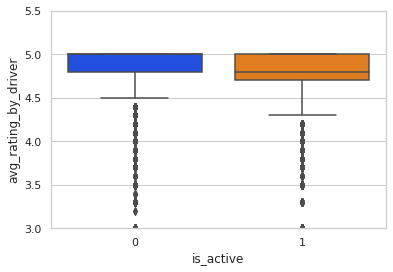

In [208]:
#Let's explore how the target variable "is_active" varies by features

#Visualize average rating by driver vs is active
sns.boxplot(x="is_active", y="avg_rating_by_driver", data=df_ultimate)
plt.ylim([3, 5.5])

In [224]:
print("Mean rating by driver:")
df_ultimate.groupby('is_active').mean()['avg_rating_by_driver']

Mean rating by driver:


is_active
0    4.786988
1    4.762739
Name: avg_rating_by_driver, dtype: float64

In [223]:
print("Median rating by driver:")
df_ultimate.groupby('is_active').median()['avg_rating_by_driver']

Median rating by driver:


is_active
0    5.0
1    4.8
Name: avg_rating_by_driver, dtype: float64

We can see above that the mean rating by driver for users who are active and not active are almost equal, but the median ratings are different. Users who aren't active actually have a higher median than the users who are active, which is interesting.

**Average distance**

(0, 20)

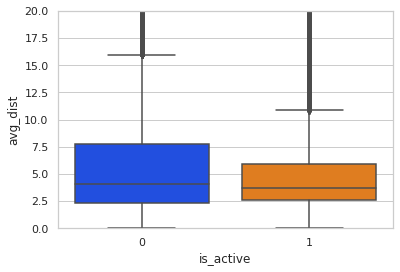

In [222]:
#Visualize average distance traveled vs is active
sns.boxplot(x="is_active", y="avg_dist", data=df_ultimate)
plt.ylim([0, 20])

In [225]:
print("Mean distance by users:")
df_ultimate.groupby('is_active').mean()['avg_dist']

Mean distance by users:


is_active
0    6.190725
1    5.113930
Name: avg_dist, dtype: float64

We can see above that the active driver actually travels a shorter distance than an inactive user, which is also interesting. This will be an important feature in the predictive model. 

**Total number of trips**

(0, 20)

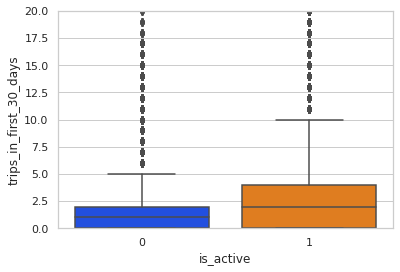

In [229]:
#Visualize number of trips vs is active
sns.boxplot(x="is_active", y="trips_in_first_30_days", data=df_ultimate)
plt.ylim([0, 20])

In [230]:
print("Average number of trips in first 30 days by users:")
df_ultimate.groupby('is_active').mean()['trips_in_first_30_days']

Average number of trips in first 30 days by users:


is_active
0    1.657033
1    3.304804
Name: trips_in_first_30_days, dtype: float64

We observe that the average number of trips in first 30 days is higher for a user who was active. 

**Weekday percentage**

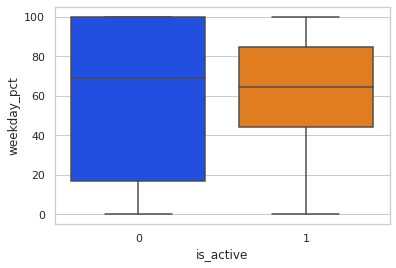

In [270]:
#Visualize number of trips vs is active
sns.boxplot(x="is_active", y="weekday_pct", data=df_ultimate)


In [271]:
print("Weekday percentage usage by users:")
df_ultimate.groupby('is_active').mean()['weekday_pct']

Weekday percentage usage by users:


is_active
0    60.605952
1    61.344208
Name: weekday_pct, dtype: float64

<font size="5">**Building the model**</font>


**Random Forest Classifier**

In [234]:
#Perform a standard scaler transformation to transform the data
scaler = StandardScaler()
scaled_features  = scaler.fit_transform(df_features)

In [235]:
# Split the data into train and test set using a 70/30 split
X_train, X_test, y_train, y_test= train_test_split(scaled_features, ultimate_target, test_size = 0.3, random_state=0)

In [253]:
# Build the random forest classifier with 1000 estimators and max_depth of 10
rf = RandomForestClassifier(n_estimators = 1000)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [254]:
## Prediction score
print("Mean accuracy score:")
rf.score(X_test, y_test)

Mean accuracy score:


0.7561483671549523

In [255]:
## Determining the accuracy of model based on different scores
scores = cross_val_score(rf, X_test, y_test, cv=5)
print("Individual mean cross validated scores:", scores)
print("Average CV score:", scores.mean())


Individual mean cross validated scores: [0.74739671 0.74672489 0.74907625 0.73521505 0.75495798]
Average CV score: 0.7466741774282936


In [257]:
## Precision recall score
precision_recall_fscore_support(y_test, y_pred)

(array([0.79892052, 0.68175962]),
 array([0.81364518, 0.66095646]),
 array([0.80621562, 0.67119688]),
 array([9278, 5604]))

In [258]:
# Confusion matrix
confusion_matrix(y_test, y_pred)

array([[7549, 1729],
       [1900, 3704]])

In [256]:
# Get feature importance
df_importance = pd.DataFrame(zip(list(df_features), list(rf.feature_importances_)), columns = ['feature', 'importance'])
df_importance.sort_values(by = 'importance', ascending = False)

feature  importance
5                    avg_dist    0.295014
4                 weekday_pct    0.132490
6        avg_rating_by_driver    0.115380
1        avg_rating_of_driver    0.082019
0      trips_in_first_30_days    0.080817
3                   surge_pct    0.079961
2                   avg_surge    0.068207
8         city_King's Landing    0.047729
11               phone_iPhone    0.019915
10              phone_Android    0.019293
13   ultimate_black_user_True    0.016607
12  ultimate_black_user_False    0.015923
7                city_Astapor    0.015666
9             city_Winterfell    0.010978

We observe that the top features that impact the predictive model are **the average distance traveled by the user, percent of trips occured on a weekday, the average rating given by the driver and the average rating of the driver**. Features such as city of user signup, Ultimate Black etc. are less important. 

The Random Forest model gives us an overall accuracy score of ~75% on the test data which is a good starting point. Next, we'll compare the performance of this model with a simple logistic regression model.

**Logistic Regression**

In [262]:
#Build a logistic regresion model with Gridsearch
lr = LogisticRegression(solver = 'lbfgs')
grid={"C":np.arange(0.5,5,0.1)}
#Instantiate the grid search model and fit
lr_cv=GridSearchCV(lr,grid,cv=5)
lr_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,
       3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,
       4.4, 4.5, 4.6, 4.7, 4.8, 4.9])},
             pre_dispatch='2*n_jobs', refit=True, return

In [263]:
# Get the best estimator
lr_cv.best_estimator_.C

0.5

In [264]:
# Fit the logistic regression model for the best estimator
logit_model = LogisticRegression(solver = 'lbfgs', C = lr_cv.best_estimator_.C )
logit_model.fit(X_train, y_train)
y_pred_logit = logit_model.predict(X_test)

In [265]:
## Prediction score
print("Mean accuracy score:")
logit_model.score(X_test, y_test)

Mean accuracy score:


0.7169735250638355

In [267]:
## Determining the accuracy of model based on different scores
scores_logit = cross_val_score(logit_model, X_test, y_test, cv=5)
print("Individual mean cross validated scores:", scores_logit)
print("Average CV score:", scores_logit.mean())

Individual mean cross validated scores: [0.72186765 0.71044676 0.71548539 0.71270161 0.7287395 ]
Average CV score: 0.7178481814312732


In [269]:
## Determining feature importance

df_importance_logit = pd.DataFrame(zip(list(df_features), list(logit_model.coef_[0])), columns = ['feature', 'importance'])
df_importance_logit.sort_values(by = 'importance', ascending = False)

feature  importance
0      trips_in_first_30_days    0.454489
8         city_King's Landing    0.432681
11               phone_iPhone    0.254349
13   ultimate_black_user_True    0.214032
3                   surge_pct    0.089791
4                 weekday_pct   -0.011873
1        avg_rating_of_driver   -0.021440
2                   avg_surge   -0.051883
9             city_Winterfell   -0.060091
6        avg_rating_by_driver   -0.078851
5                    avg_dist   -0.202945
12  ultimate_black_user_False   -0.214032
10              phone_Android   -0.254349
7                city_Astapor   -0.306119

We observe that the Random Forest Classifier actually performs better than the Logistic Regression model with a slightly higher accuracy score. Thus, we conclude that the model has a predictive accuracy of ~75% and the important features for the predictive model are:

1)**Average distance traveled by the user** - Previously, we observed that the average user who is active actually travels a shorter distance than an inactive user. The logistic regression model also showed a similar trend. Thus, traveling lower distances could indicate that a user may be "active"

2)**Percent of trips occured on a weekday** - We observe that chances of being an active user actually reduces as the weekday percentage goes up. Ultimate might benefit from encouraging the users to use the app more often on weekends than weekdays

3)**Average rating given by the driver** - We observe that the chances of being an active user goes down as your rating goes up.

4)**Average rating of the driver** - We observe that the chances of being an active user goes down as the driver rating goes down. 

5)**Trip distance in the first 30 days** - As the number of trips in the first 30 days increases, the chance that a rider is active in the past 6 months also goes up



One thing to note in this analysis is, we set the 'current date' or the date to determine whether a user has been active in the past six months or note based on the lastest active data in the dataset. However, a different current date could potentially impact the findings here. 

There are several recommendations we can give the company to increase their ridership and long-term retention:
    
    1) Encourage the users to make more trips within the first 30 days of signing up by giving them discounts and offers. 
    2) Encourage the users to use the app more often on weekends by reducing price surge and offering more discount
    3) Encourage drivers to not artifically increase the ratings that they give users
    4) Finally, ensure the drivers get a good rating by giving them incentives for getting high ratings from users. 
    